In [9]:
import os.path as op
from os import makedirs
import numpy as np
from scipy import stats
import nibabel as nib
from nilearn.surface import load_surf_data
from nilearn.glm.first_level import (
    make_first_level_design_matrix,
    first_level_from_bids,
)
from nilearn import image
from nilearn.glm.first_level.first_level import run_glm
from nilearn.glm.contrasts import compute_contrast
import nilearn
from bids import BIDSLayout

import argparse
from argparse import RawDescriptionHelpFormatter

import logging
import sys
import concurrent.futures
import csv
import pandas as pd


logger = logging.getLogger("GENERAL")


# %% parser
def get_parser():
    """
    Input:
    Parse command line inputs

    Returns:
    a dict stores information about the cmd input

    """
    parser = argparse.ArgumentParser(
        description="""
        Python script to batch run MINI subjectsurface based fMRI first level analysis        
""",
        formatter_class=RawDescriptionHelpFormatter,
    )
    parser.add_argument(
        "-base",
        type=str,
        # default="",
        help="basedir e.g. /bcbl/home/public/Gari/VOTCLOC/main_exp",
    )
    parser.add_argument(
        "-i",
        type=str,
        # default="",
        help="input bids dir name, default is BIDS",
    )    

    parser.add_argument(
        "-sub",
        type=str,
        # default="",
        help="subject id, e.g. S005",
    )
    parser.add_argument(
        "-ses",
        type=str,
        # default="",
        help="ses id, e.g. T01",
    )
    parser.add_argument(
        "-fp_ana_name",
        type=str,
        # default="",
        help="analysis name of the fmriprep, the src input to this ",
    )
    parser.add_argument(
        "-output_name",
        type=str,
        # default="",
        help="output folder name ",
    )   
    parser.add_argument(
        "-slice_time_ref",
        type=float,
        default="0.5",
        help="slice timeing, default fmriprep 0.5, we set 0 sometimes ",
        required=False
    )   

    parser.add_argument(
        "-use_smoothed",
        action='store_true',
        help="use_smooth, e.g. True or False",
    )

    parser.add_argument(
        "-sm",
        type=str,
        default="",
        help="freesurfer fwhm smooth factor, 01 02 03 04 05 010",
        required=False
    )




    parse_dict = vars(parser.parse_args())
    parse_namespace = parser.parse_args()

    return parse_dict
### Helper function for saving GIFTI statmaps
def save_statmap_to_gifti(data, outname):
    """Save a statmap to a gifti file.
    data: nilearn contrast model output, e.g., contrast.effect_size()
    outname: output file name
    """
    gii_to_save = nib.gifti.gifti.GiftiImage()
    gii_to_save.add_gifti_data_array(
        nib.gifti.gifti.GiftiDataArray(data=data, datatype="NIFTI_TYPE_FLOAT32")
    )
    nib.save(gii_to_save, outname)


#%%
# Function to replace prefix
def replace_prefix(val):
    if isinstance(val, str) and (val.startswith('EU_') or val.startswith('ES_') or \
        val.startswith('EN_') or val.startswith('FR_') or val.startswith('IT_') or val.startswith('CN_') or val.startswith('ZH_') or val.startswith('JP_')):
        return val[3:]
    else:
        return val


In [4]:
    bids='/bcbl/home/public/Gari/VOTCLOC/main_exp/BIDS'
    input_bids= '/bcbl/home/public/Gari/VOTCLOC/main_exp/BIDS'
    subject='04'
    session='02'
    slice_time_ref=0.5
    fp_ana_name='beforeFebST05' 
    output_name='test_sub04'
    use_smoothed=False
    hemi="L"

In [3]:
    fmriprep_dir = op.join(bids,
        "derivatives", "fmriprep" ,f'analysis-{fp_ana_name}'
    )  # BIDS-relative path to fMRIPrep
    task = "fLoc"  # Task name
    space = "fsnative"  # BOLD projected on subject's freesurfer surface
    hemis = ["L","R"]     #, "R"]  # L for left, R for right
    #use_smoothed = False
    run_nums = ["01","02", "03", "04", "05", "06","07","08","09","10"] # Runs to process
    #slice_time_ref = (
    #    0  #0.5 or 0 From the fMRIPrep command, align slice time correction to start of TR
    #)
    fsdir=f'{fmriprep_dir}/sourcedata/freesurfer'
    
    surf_dir = f"{fsdir}/sub-{subject}/surf"
    label_dir = f"{fsdir}/sub-{subject}/label"

    ### Define output directory
    outdir = op.join(bids, "derivatives", "l1_surface",f"analysis-{output_name}", f'sub-{subject}',f'ses-{session}')

    if not op.exists(outdir):
        makedirs(outdir)

In [8]:
    for hemi in hemis:
        print("Processing hemi", hemi)
        
        ### Final output dictionary for GLM contrast results (to be combined across runslater)
        contrast_objs = {}
        gii_allrun=[]
        frame_time_allrun=[]
        events_allrun=[]
        confounds_allrun=[]
        store_l1=[]
        ### Loop over runs
        for idx, run_num in enumerate(run_nums):
            print("Processing run", run_num)

            ### Load GIFTI data and z-score it
            run = (
                "run-" + run_num
            )  # Run string in filename (define as empty string "" if no run label)
            func_name = (
                f"sub-{subject}_ses-{session}_task-{task}_{run}_hemi-{hemi}_space-{space}_bold.func.gii"
            )
            # If you smoothed data beforehand, make sure to point this to your smoothed file name!
            print(f"smooth is {use_smoothed}")
            if use_smoothed:
                func_name = func_name.replace("_bold", f"_desc-smoothed{sm}_bold")
            nii_path = op.join(fmriprep_dir, f'sub-{subject}', f"ses-{session}" ,"func", func_name)
            gii_data = load_surf_data(nii_path)
            
            # remove the first 6 volumns of all runs and then concat them
             
            gii_data_float=np.vstack(gii_data[:,:]).astype(float)
            gii_remove_first_6=gii_data_float[:,6::]
            gii_data_std = stats.zscore(gii_remove_first_6, axis=1)
            
            gii_allrun.append(gii_data_std)
        
            # # freesurfer label file
            # label_path=(f'{label_dir}/lh.votcnov1v2.label')
            # mask_votc= load_surf_data(label_path)
            
            
            # ### Get shape of data
            n_vertices = np.shape(gii_data_std)[0]
            n_scans = np.shape(gii_data_std)[1]
            
            # votc_label_dir=f'{label_dir}/lh.votcnov1v2.label'
            # votc_label=load_surf_data(votc_label_dir)
            # mask=np.zeros((n_vertices,1))
            # mask[votc_label]=1
            
            # gii_data_std=gii_data_std*mask
            # gii_data_float=gii_data_float*mask
            #gii_data_std_masked=nilearn.masking.apply_mask(gii_data_std, mask_votc, dtype='f', smoothing_fwhm=None, ensure_finite=True)            
            ### Use the volumetric data just to get the events and confounds file           
            img_filters = [("desc", "preproc")]
            # specify session 
            img_filters.append(("ses", session))
            # If multiple runs are present, then add the run number to filter to specify
            if len(run) > 0:
                img_filters.append(("run", run_num))
            l1 = first_level_from_bids(
                input_bids,
                task,
                space_label="T1w",
                sub_labels=[subject],
                slice_time_ref=slice_time_ref,
                hrf_model="spm",
                drift_model=None,  # Do not high_pass since we use fMRIPrep's cosine regressors
                drift_order=0,  # Do not high_pass since we use fMRIPrep's cosine regressors
                high_pass=None,  # Do not high_pass since we use fMRIPrep's cosine regressors
                img_filters=img_filters,
                derivatives_folder=fmriprep_dir,
            )

            ### Extract information from the prepared model
            t_r = l1[0][0].t_r
            events = l1[2][0][0]  # Dataframe of events information
            confounds = l1[3][0][0]  # Dataframe of confounds
            # get rid of rest so that the setting would be the same as spm
            events_nobaseline=events[events.loc[:,'trial_type']!='baseline']
            events_nobaseline.loc[:,'onset']=events_nobaseline['onset']+idx*(n_scans)*t_r
            
            events_allrun.append(events_nobaseline)
            store_l1.append(l1)
            ### From the confounds file, extract only those of interest
            # Start with the motion and acompcor regressors
            motion_keys = [
                "framewise_displacement",
                "rot_x",
                "rot_y",
                "rot_z",
                "trans_x",
                "trans_y",
                "trans_z",
            ]
            # Get ACompCor components (all to explain 50% variance)
            a_compcor_keys = [key for key in confounds.keys() if "a_comp_cor" in key]

            # Now add non-steady-state volumes
            non_steady_state_keys = [key for key in confounds.keys() if "non_steady" in key]

            # Add cosine regressors which act to high-pass filter data at 1/128 Hz
            cosine_keys = [key for key in confounds.keys() if "cosine" in key]

            # Pull out the confounds we want to keep
            confound_keys_keep = (
                motion_keys + a_compcor_keys + cosine_keys + non_steady_state_keys
            )
            confounds_keep = confounds[confound_keys_keep]

            # Set first value of FD column to the column mean
            confounds_keep["framewise_displacement"][0] = np.nanmean(
                confounds_keep["framewise_displacement"]
            )
            confounds_keep=confounds_keep.iloc[6:]
            confounds_allrun.append(confounds_keep)
            ### Create the design matrix
            # Start by getting times of scans
            frame_times = t_r * ((np.arange(n_scans) + slice_time_ref)+idx*n_scans)
            # Now use Nilearn to create the design matrix from the events files
            frame_time_allrun.append(frame_times)
        


Processing hemi L
Processing run 01
smooth is False


/export/home/tlei/tlei/soft/miniconda3/envs/votcloc/lib/python3.11/site-packages/nilearn/glm/first_level/first_level.py:1621: UserWarning: 'slice_time_ref' provided (0.5) is different from the value found in the BIDS dataset (0.464).
Note this may lead to the wrong model specification.
  warn(
/scratch/tlei/ipykernel_2559900/2648382440.py:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the origina

Processing run 02
smooth is False


/export/home/tlei/tlei/soft/miniconda3/envs/votcloc/lib/python3.11/site-packages/nilearn/glm/first_level/first_level.py:1621: UserWarning: 'slice_time_ref' provided (0.5) is different from the value found in the BIDS dataset (0.464).
Note this may lead to the wrong model specification.
  warn(
/scratch/tlei/ipykernel_2559900/2648382440.py:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the origina

Processing run 03
smooth is False


/export/home/tlei/tlei/soft/miniconda3/envs/votcloc/lib/python3.11/site-packages/nilearn/glm/first_level/first_level.py:1621: UserWarning: 'slice_time_ref' provided (0.5) is different from the value found in the BIDS dataset (0.464).
Note this may lead to the wrong model specification.
  warn(
/scratch/tlei/ipykernel_2559900/2648382440.py:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the origina

Processing run 04
smooth is False


/export/home/tlei/tlei/soft/miniconda3/envs/votcloc/lib/python3.11/site-packages/nilearn/glm/first_level/first_level.py:1621: UserWarning: 'slice_time_ref' provided (0.5) is different from the value found in the BIDS dataset (0.4645).
Note this may lead to the wrong model specification.
  warn(
/scratch/tlei/ipykernel_2559900/2648382440.py:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the origin

Processing run 05
smooth is False


/export/home/tlei/tlei/soft/miniconda3/envs/votcloc/lib/python3.11/site-packages/nilearn/glm/first_level/first_level.py:1621: UserWarning: 'slice_time_ref' provided (0.5) is different from the value found in the BIDS dataset (0.4645).
Note this may lead to the wrong model specification.
  warn(
/scratch/tlei/ipykernel_2559900/2648382440.py:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the origin

Processing run 06
smooth is False


/export/home/tlei/tlei/soft/miniconda3/envs/votcloc/lib/python3.11/site-packages/nilearn/glm/first_level/first_level.py:1621: UserWarning: 'slice_time_ref' provided (0.5) is different from the value found in the BIDS dataset (0.4645).
Note this may lead to the wrong model specification.
  warn(
/scratch/tlei/ipykernel_2559900/2648382440.py:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the origin

Processing run 07
smooth is False


/export/home/tlei/tlei/soft/miniconda3/envs/votcloc/lib/python3.11/site-packages/nilearn/glm/first_level/first_level.py:1621: UserWarning: 'slice_time_ref' provided (0.5) is different from the value found in the BIDS dataset (0.464).
Note this may lead to the wrong model specification.
  warn(
/scratch/tlei/ipykernel_2559900/2648382440.py:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the origina

Processing run 08
smooth is False


/export/home/tlei/tlei/soft/miniconda3/envs/votcloc/lib/python3.11/site-packages/nilearn/glm/first_level/first_level.py:1621: UserWarning: 'slice_time_ref' provided (0.5) is different from the value found in the BIDS dataset (0.464).
Note this may lead to the wrong model specification.
  warn(
/scratch/tlei/ipykernel_2559900/2648382440.py:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the origina

Processing run 09
smooth is False


/export/home/tlei/tlei/soft/miniconda3/envs/votcloc/lib/python3.11/site-packages/nilearn/glm/first_level/first_level.py:1621: UserWarning: 'slice_time_ref' provided (0.5) is different from the value found in the BIDS dataset (0.464).
Note this may lead to the wrong model specification.
  warn(
/scratch/tlei/ipykernel_2559900/2648382440.py:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the origina

Processing run 10
smooth is False


/export/home/tlei/tlei/soft/miniconda3/envs/votcloc/lib/python3.11/site-packages/nilearn/glm/first_level/first_level.py:1621: UserWarning: 'slice_time_ref' provided (0.5) is different from the value found in the BIDS dataset (0.464).
Note this may lead to the wrong model specification.
  warn(
/scratch/tlei/ipykernel_2559900/2648382440.py:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the origina

NameError: name 'replace_prefix' is not defined

In [10]:
        conc_gii_data_std=np.concatenate(gii_allrun, axis=1)
        concat_frame_times=np.concatenate(frame_time_allrun, axis=0)
        concat_events=pd.concat(events_allrun, axis=0)
	    # Applying the function to the entire DataFrame
        concat_events = concat_events.map(replace_prefix)
        concat_confounds=pd.concat(confounds_allrun, axis=0)
        nonan_confounds=concat_confounds.dropna(axis=1, how='any')
        
        design_matrix = make_first_level_design_matrix(
            concat_frame_times,
            events=concat_events,
            hrf_model="spm",  # convolve with SPM's canonical HRF function
            drift_model=None,  # we use fMRIPrep's cosine regressors
            add_regs=nonan_confounds,
        )


        # set the design matrix's NaN value to 0?
        


/scratch/tlei/ipykernel_2559900/633752591.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  concat_events = concat_events.applymap(replace_prefix)
/export/home/tlei/tlei/soft/miniconda3/envs/votcloc/lib/python3.11/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [68]:
        # z-score the design matrix to standardize it
        design_matrix_std = design_matrix.apply(stats.zscore, axis=0)


In [69]:
        # add constant in to standardized design matrix since you cannot z-score a constant
        design_matrix_std["constant"] = np.ones(len(design_matrix_std)).astype(int)

In [66]:
np.ones(len(design_matrix_std)).astype(int)

array([1, 1, 1, ..., 1, 1, 1], shape=(1530,))

In [67]:
design_matrix_std["constant"]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [64]:
design_matrix_std

array([[-4.40097228e-01, -4.38313234e-01, -4.40650311e-01, ...,
        -1.87238836e+00, -8.51089409e-01,  4.35332176e+00],
       [-4.40097228e-01, -4.38313234e-01, -4.40650311e-01, ...,
         2.62723058e-01,  2.28738672e-01, -1.74132870e+00],
       [-4.40097228e-01, -4.38313234e-01, -4.40650311e-01, ...,
         4.54681933e-01,  2.66478435e-01,  6.82020409e+00],
       ...,
       [-4.40394755e-01, -5.60889490e-01,  5.30655692e-01, ...,
         3.71278393e-02, -3.81987455e-02,  8.70664352e-01],
       [-4.40097228e-01, -5.03518968e-01, -2.67448268e-01, ...,
         4.02180850e-03, -6.80293267e-02,  1.30599653e+00],
       [-4.40097228e-01, -4.69382592e-01, -6.42937466e-01, ...,
        -1.04648656e-01, -6.97771598e-02,  1.16088580e+00]],
      shape=(1530, 38))

In [16]:
#Plot designmatrix
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt



In [35]:
nonan_confounds

,framewise_displacement,rot_x,rot_y,rot_z,trans_x,trans_y,trans_z,a_comp_cor_00,a_comp_cor_01,a_comp_cor_02,...,a_comp_cor_14,cosine00,cosine01,cosine02,non_steady_state_outlier00,non_steady_state_outlier01,non_steady_state_outlier02,non_steady_state_outlier03,non_steady_state_outlier04,non_steady_state_outlier05
6,0.057532,0.001112,-0.000000e+00,-0.000099,0.017222,0.017671,0.055823,-0.016051,0.076971,-0.034750,...,-0.098883,0.114326,0.114308,0.114278,0.0,0.0,0.0,0.0,0.0,0.0
7,0.059849,0.001206,2.646980e-23,-0.000162,0.011973,-0.013871,0.040646,-0.004201,0.080735,-0.043292,...,-0.106578,0.114278,0.114116,0.113845,0.0,0.0,0.0,0.0,0.0,0.0
8,0.041949,0.001112,-0.000000e+00,-0.000131,0.013773,0.002359,0.023007,0.000974,0.074915,-0.055573,...,-0.141900,0.114182,0.113730,0.112979,0.0,0.0,0.0,0.0,0.0,0.0
9,0.063728,0.000700,-0.000000e+00,-0.000154,0.011805,0.024773,0.040644,0.008286,0.085741,-0.057060,...,-0.072918,0.114037,0.113153,0.111685,0.0,0.0,0.0,0.0,0.0,0.0
10,0.025131,0.000700,1.323490e-23,-0.000162,0.008863,0.002998,0.040644,0.006295,0.088272,-0.046313,...,-0.024374,0.113845,0.112386,0.109968,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,0.305316,-0.002449,-1.993650e-03,0.001039,0.065587,0.101467,-0.108858,-0.166830,-0.018012,-0.003352,...,-0.017514,-0.113845,0.112386,-0.109968,0.0,0.0,0.0,0.0,0.0,0.0
155,0.158947,-0.002177,-2.409150e-03,0.001074,0.071691,-0.000628,-0.094214,-0.156162,0.026282,-0.024249,...,0.072470,-0.114037,0.113153,-0.111685,0.0,0.0,0.0,0.0,0.0,0.0
156,0.117907,-0.002572,-2.288040e-03,0.000953,0.071708,0.055701,-0.064535,-0.153184,0.043634,-0.023370,...,-0.027296,-0.114182,0.113730,-0.112979,0.0,0.0,0.0,0.0,0.0,0.0
157,0.081613,-0.002599,-2.501140e-03,0.000893,0.071688,0.000119,-0.053508,-0.111716,0.088269,-0.017063,...,0.035490,-0.114278,0.114116,-0.113845,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
concat_frame_times[0:153].size

153

/export/home/tlei/tlei/soft/miniconda3/envs/votcloc/lib/python3.11/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


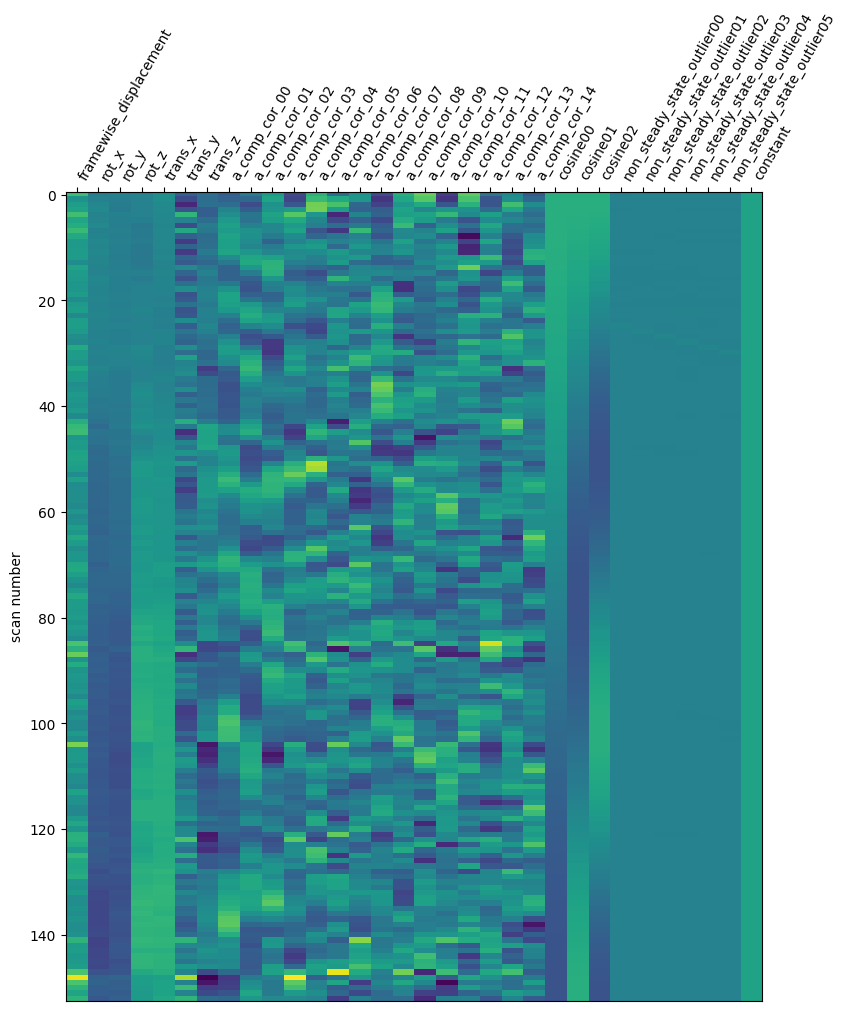

In [58]:
i=10
#runi=[0,152]*i
design_matrix_runi = make_first_level_design_matrix(
            concat_frame_times[0:153]+153*(i-1),
            events=concat_events.iloc[0+153*(i-1):int(153+153*(i-1)/3),:],
            hrf_model="spm",  # convolve with SPM's canonical HRF function
            drift_model=None,  # we use fMRIPrep's cosine regressors
            add_regs=nonan_confounds.iloc[0+153*(i-1):153*i,:]
        )

plot_design_matrix(design_matrix_runi)
plt.show()

In [70]:
        ### Run the GLM
        # Y std or not?
        Y = np.transpose(conc_gii_data_std)
        X = np.asarray(design_matrix_std)
        labels, estimates = run_glm(Y, X, n_jobs=-1)

        ### Define the contrasts
        contrast_matrix = np.eye(design_matrix.shape[1])
        basic_contrasts = dict(
            [
                (column, contrast_matrix[i])
                for i, column in enumerate(design_matrix.columns)
            ]
        )
        contrasts = {
        "AllvsNull": (
            basic_contrasts["face"] 
            + basic_contrasts["bodylimb"] 
            + basic_contrasts["RW"] 
            + basic_contrasts["FF"] 
            + basic_contrasts["CS"] 
            + basic_contrasts["SC"] 
        ),
        "PERvsNull": (
            + basic_contrasts["SC"] 
        ),
        "LEXvsNull": (
            basic_contrasts["CS"] 
            + basic_contrasts["FF"] 
        ),    
        "PERvsLEX": (
            + basic_contrasts["SC"]
            - basic_contrasts["CS"] / 2
            - basic_contrasts["FF"] / 2
        ),          
        "RWvsLEX": (
            basic_contrasts["RW"] 
            - basic_contrasts["CS"] / 2
            - basic_contrasts["FF"] / 2
        ),  
        "RWvsPER": (
            basic_contrasts["RW"] 
            - basic_contrasts["SC"]
        ),  
        "RWvsNull": (
            basic_contrasts["RW"] 
        ), 
        "RWvsLEXPER": (
            basic_contrasts["RW"] 
            - basic_contrasts["CS"] / 3
            - basic_contrasts["FF"] / 3
            - basic_contrasts["SC"] / 3
        ),     
        "RWvsAllnoWordnoLEX": (
            basic_contrasts["RW"] 
            - basic_contrasts["SC"] / 3
            - basic_contrasts["bodylimb"] / 3
            - basic_contrasts["face"] / 3
        ),
        
        "RWvsAllnoWord": (
            basic_contrasts["RW"] 
            - basic_contrasts["CS"] / 5
            - basic_contrasts["FF"] / 5                
            - basic_contrasts["SC"] / 5
            - basic_contrasts["bodylimb"] / 5
            - basic_contrasts["face"] / 5
        ),     
        "LEXvsAllnoLEXnoRW": (
            basic_contrasts["CS"] / 2
            + basic_contrasts["FF"] / 2
            - basic_contrasts["SC"] / 3
            - basic_contrasts["bodylimb"] / 3
            - basic_contrasts["face"] / 3
        ),     
        "PERvsAllnoLEXnoRW": (
            + basic_contrasts["SC"]
            - basic_contrasts["CS"] / 4
            - basic_contrasts["FF"] / 4
            - basic_contrasts["bodylimb"] / 4
            - basic_contrasts["face"] / 4
        ),         
        "CSvsFF": (
            basic_contrasts["CS"] 
            - basic_contrasts["FF"] 
            
        ),     
        "FacesvsNull": (
            basic_contrasts["face"] 
        ),    
        "FacesvsLEX": (
            basic_contrasts["face"]
            - basic_contrasts["CS"] / 2
            - basic_contrasts["FF"]  / 2
        ), 
        "FacesvsPER": (
            basic_contrasts["face"]
            - basic_contrasts["SC"] 
        ),    
        "FacesvsLEXPER": (
            basic_contrasts["face"]
            - basic_contrasts["SC"]  / 3
            - basic_contrasts["CS"] / 3
            - basic_contrasts["FF"]  / 3                
        ),   
        "FacesvsAllnoFace": (
            basic_contrasts["face"]
            - basic_contrasts["SC"]  / 4
            - basic_contrasts["CS"] / 4
            - basic_contrasts["FF"]  / 4  
            - basic_contrasts["bodylimb"] / 4
        ),  
        "LimbsvsNull": (
            basic_contrasts["bodylimb"] 
        ),    
        "LimbsvsLEX": (
            basic_contrasts["bodylimb"] 
            - basic_contrasts["CS"] / 2
            - basic_contrasts["FF"]  / 2
        ), 
        "LimbsvsPER": (
            basic_contrasts["bodylimb"] 
            - basic_contrasts["SC"] 
        ),    
        "LimbsvsLEXPER": (
            basic_contrasts["bodylimb"] 
            - basic_contrasts["SC"]  / 3
            - basic_contrasts["CS"] / 3
            - basic_contrasts["FF"]  / 3                
        ),   
        "LimbsvsAllnoLimbs": (
            basic_contrasts["bodylimb"] 
            - basic_contrasts["SC"]  / 4
            - basic_contrasts["CS"] / 4
            - basic_contrasts["FF"]  / 4 
            - basic_contrasts["face"] / 4           
        ),                                                                                                                                                        
        "RWvsCS": (
             basic_contrasts["RW"] 
            - basic_contrasts["CS"] 
  
        ),        
        "RWvsFF": (
             basic_contrasts["RW"] 
            - basic_contrasts["FF"] 
  
        ),  
        "RWvsFace": (
             basic_contrasts["RW"] 
            - basic_contrasts["face"] 
  
        ),  
        "RWvsLimbs": (
             basic_contrasts["RW"] 
            - basic_contrasts["bodylimb"] 
  
        ),          
        "RWvsSD": (
             basic_contrasts["RW"] 
            - basic_contrasts["SC"] 
  
        )           
    }

            ### Compute the contrasts
        for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
            # Add a label to the output dictionary if not present
            if contrast_id not in contrast_objs:
                contrast_objs[contrast_id] = []
                
            # Define a name template for output statistical maps (stat-X is replaced later on)
            outname_base_run = f"sub-{subject}_ses-{session}_task-{task}_hemi-{hemi}_space-{space}_contrast-{contrast_id}_stat-X_statmap.func.gii"
            if use_smoothed:
                outname_base_run = outname_base_run.replace(
                    "_statmap", f"_desc-smoothed{sm}_statmap"
                )
            outname_base_run = op.join(outdir, outname_base_run)  # Place in output directory

            # compute contrast-related statistics
            contrast = compute_contrast(
                labels, estimates, contrast_val, contrast_type="t"
            )
            # add contrast to the output dictionary
            contrast_objs[contrast_id].append(contrast)

            # do the run-specific processing
            betas = contrast.effect_size()
            z_score = contrast.z_score()
            t_value = contrast.stat()
            p_value = contrast.p_value()
            variance = contrast.effect_variance()

            # Save the value maps as GIFTIs
            # Effect size
            outname = outname_base_run.replace("stat-X", "stat-effect")
            save_statmap_to_gifti(betas, outname)

            # z-score
            outname = outname_base_run.replace("stat-X", "stat-z")
            save_statmap_to_gifti(z_score, outname)

            # t-value
            outname = outname_base_run.replace("stat-X", "stat-t")
            save_statmap_to_gifti(t_value, outname)

            # p-value
            outname = outname_base_run.replace("stat-X", "stat-p")
            save_statmap_to_gifti(p_value, outname)

            # variance
            outname = outname_base_run.replace("stat-X", "stat-variance")
            save_statmap_to_gifti(variance, outname)

/export/home/tlei/tlei/soft/miniconda3/envs/votcloc/lib/python3.11/site-packages/nilearn/glm/first_level/first_level.py:216: RuntimeWarning: invalid value encountered in cast
  ar_coef_[idx] = (ar_coef_[idx] * bins).astype(int) * 1.0 / bins


KeyError: 'RW'

In [71]:
basic_contrasts

{'AT_CS': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
 'AT_FF': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
 'AT_RW': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
 'AT_SC': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
 'bodylimb': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
 'face': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.